In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# IO

In [2]:

toload = {
    "base" : "stc1a-vis_1600",
    "mxorder1" : "stc2a-mxorder1"
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(os.path.join(onedrive_path, rf"Project\collab\tech\cases\step1d_shocktests\{toload[name]}"))


Loading stc1a-vis_1600


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc2a-mxorder1


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


In [4]:
write_file(cs, "a2b.pkl")

a2b.pkl written


In [9]:
cs = read_file("a2b.pkl")

a2.pkl loaded


# Plots

In [ ]:
%matplotlib widget

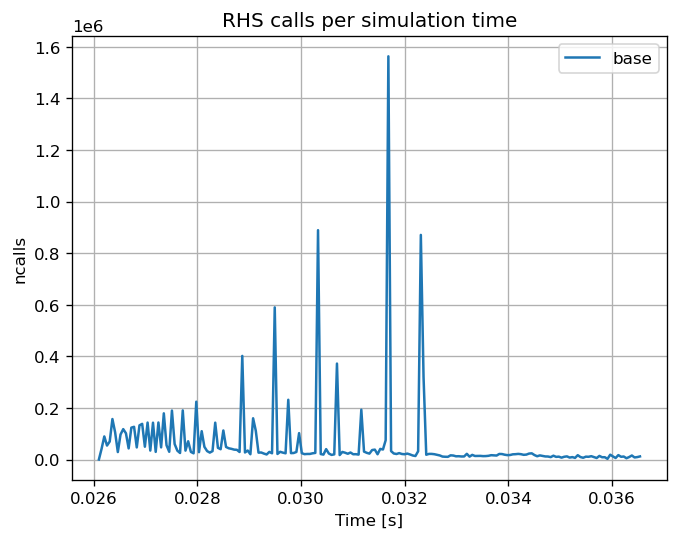

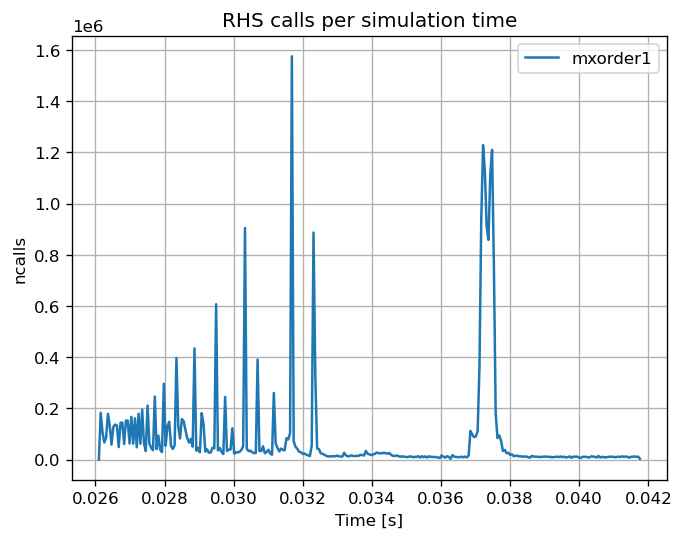

In [67]:


for name in toload:
    fig, ax = plt.subplots(dpi = 120)
    cs[name].ds["ncalls"].plot(ax = ax, label = name)
    ax.set_title("RHS calls per simulation time")
    ax.legend()
    ax.grid()

## Analysis of the secondary slowdown

### Residuals
- Clear spike in Pe only.

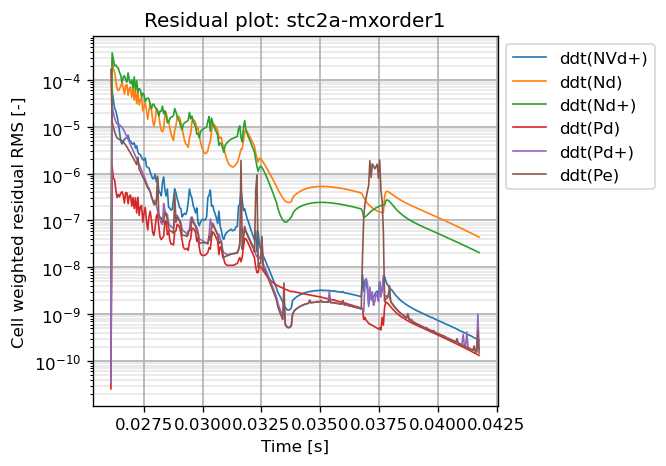

In [21]:
plot_ddt(cs["mxorder1"])

### Plotting Pe
- Literally nothing happening. the profile is just settling.

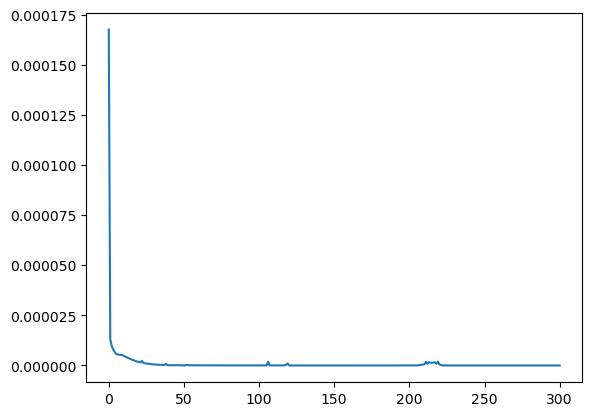

In [34]:
list_params = ["ddt(Pe)"]
ds = cs["mxorder1"].ds.isel(pos=slice(2,-2))
volume_weighted=True
res = dict()
smoothing = 1

for param in list_params:

    if volume_weighted:
        res[param] = (ds[param] * ds.dv) / np.sum(ds.dv)    # Cell volume weighted
    else:
        res[param] = ds[param]
        

    res[param] = np.sqrt(np.mean(res[param]**2, axis = 1))    # Root mean square
    res[param] = np.convolve(res[param], np.ones(smoothing), "same")    # Moving average with window = smoothing
    
plt.plot(res["ddt(Pe)"])

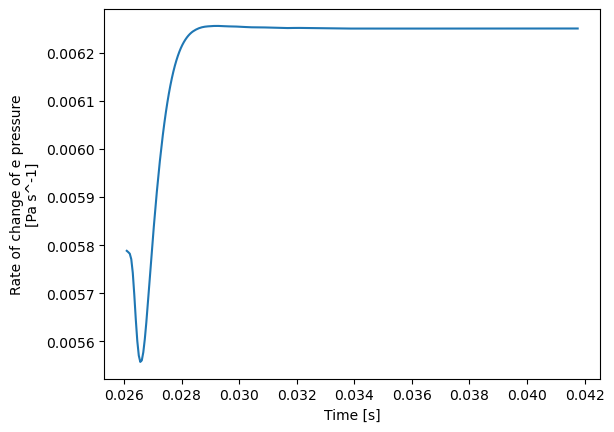

In [22]:
ds = cs["mxorder1"].ds
res = (ds["ddt(Pe)"] * ds["dv"]) / np.sum(ds["dv"])
res = np.sqrt(np.mean(res**2, axis = 1))
res.plot()

In [59]:
%matplotlib inline

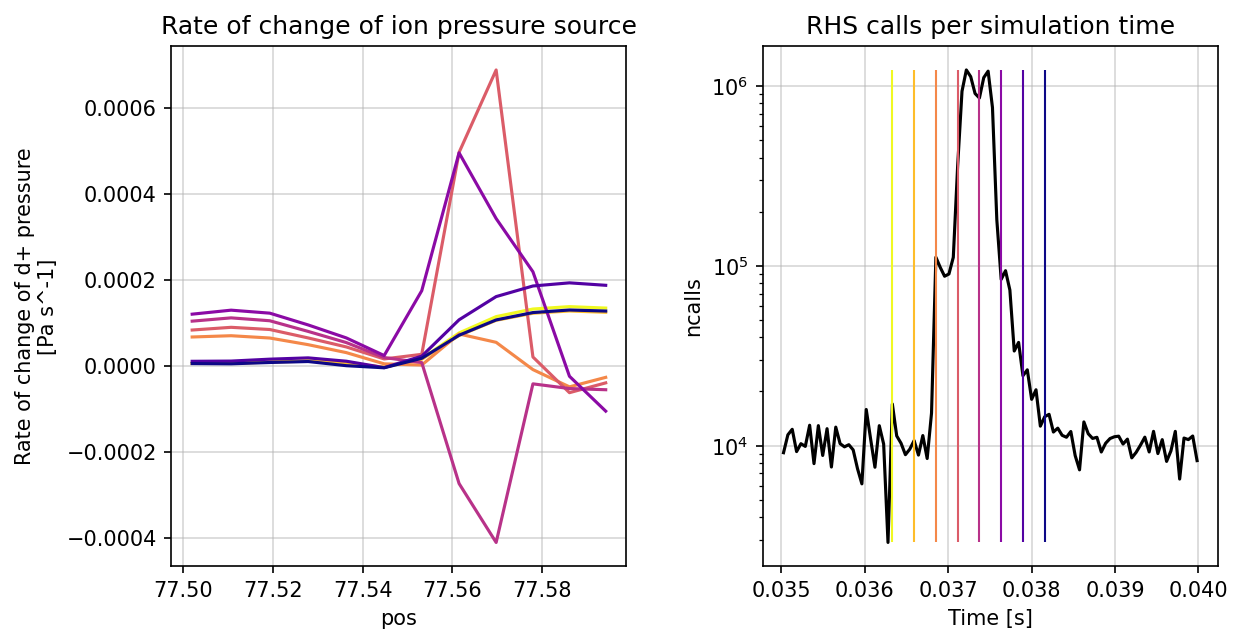

In [61]:
ds = cs["mxorder1"].ds.isel(pos=slice(2,-2))
ds_spike = ds.sel(pos = slice(77.50, 77.60), t = slice(0.035, 0.04))

fig, axes = plt.subplots(1, 2, figsize = (9, 4.5), dpi = 150)
fig.subplots_adjust(wspace = 0.3)

time_idx = np.arange(25, 65, 5)
# time_idx = [0, 5, 10]
times = ds_spike["t"].isel(t = time_idx)
colors = make_cmap("plasma", len(times))[::-1]

ax = axes[0]

for i, t in enumerate(time_idx):
    ds_spike["ddt(Pd+)"].isel(t=t).plot(ax = ax, c = colors[i])
# ax.set_yscale("log")
ax.set_title("Rate of change of ion pressure source")



ax = axes[1]
# res = (ds["ddt(Pe)"] * ds["dv"]) / np.sum(ds["dv"])
# res = np.sqrt(np.mean(res**2, axis = 1))

res = ds_spike["ncalls"]
res.plot(ax = ax, c = "k")

ax.vlines(times, res.min(), res.max(), colors = colors, lw = 1)
ax.set_yscale("log")
ax.set_title("RHS calls per simulation time")
for ax in axes:
    ax.grid(alpha = 0.5)
    


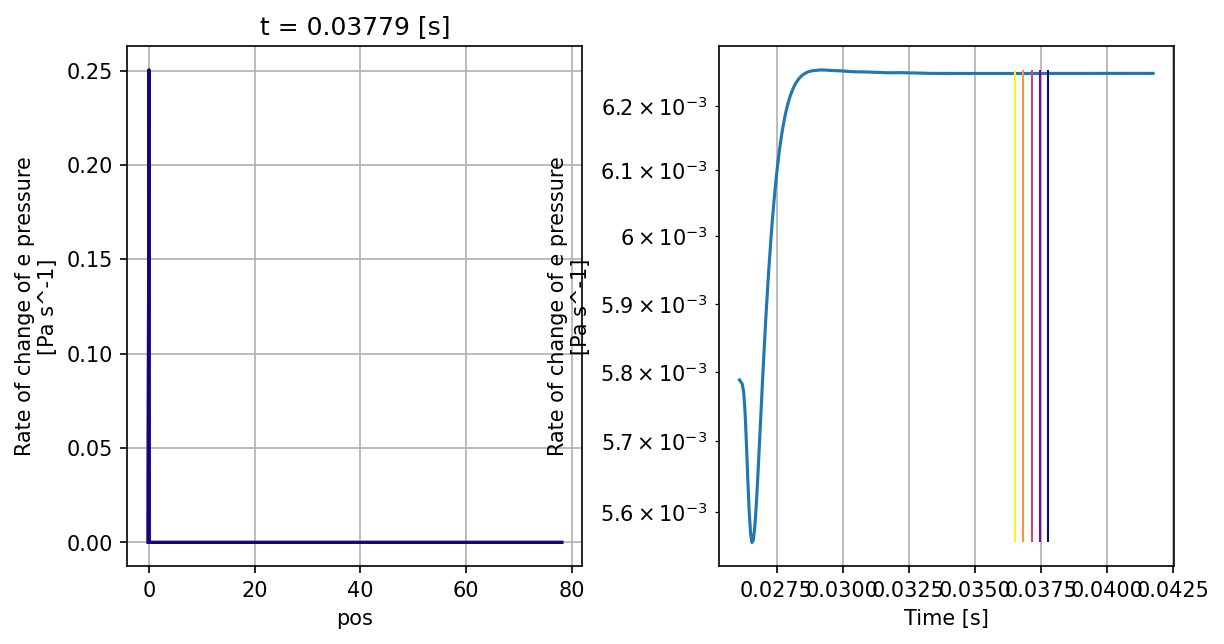

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (9, 4.5), dpi = 150)
fig.subplots_adjust(wspace = 0.3)

time_idx = np.arange(200, 230, 6)
times = ds["t"].isel(t = time_idx)
colors = make_cmap("plasma", len(times))[::-1]
res = (ds["ddt(Pe)"] * ds["dv"]) / np.sum(ds["dv"])


ax = axes[0]

for i, t in enumerate(time_idx):
    res.isel(t=t).plot(ax = ax, c = colors[i])
# ax.set_yscale("log")
ax.grid()

ax = axes[1]

meanres = np.sqrt(np.mean(res**2, axis = 1))
meanres.plot(ax = ax)

ax.vlines(times, meanres.min(), meanres.max(), colors = colors, lw = 1)
ax.set_yscale("log")
ax.grid()

In [79]:
%matplotlib inline

In [101]:
param

'Pe_src'

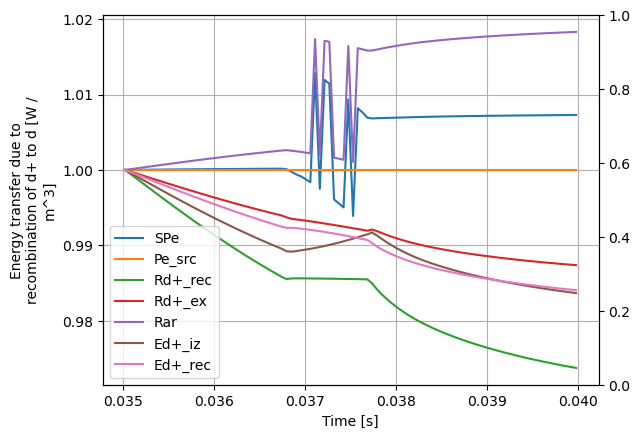

In [112]:
ds_spike = ds.sel(pos = slice(77.50, 77.60), t = slice(0.035, 0.04))
ds_sum = ds_spike.sum("pos")


fig, ax = plt.subplots()
ax2 = ax.twinx()

# ds_sum["ddt(Pe)"].plot(ax = ax2, label = "Total", lw = 3, c = "k", alpha = 0.3, ls = "--")

for param in ["SPe", "Pe_src", "Rd+_rec", "Rd+_ex", "Rar", "Ed+_iz", "Ed+_rec"]:
    data = ds_sum[param]
    first = data.isel(t=0)
    
    if first != 0:
        data = data/first
    else:
        data += 1
    
    data.plot(ax = ax, label = param)

ax.grid()
ax.legend()
# ax.set_yscale("symlog")

Text(0.5, 1.0, 'Integral of argon radiation in low temperature region (10cm)')

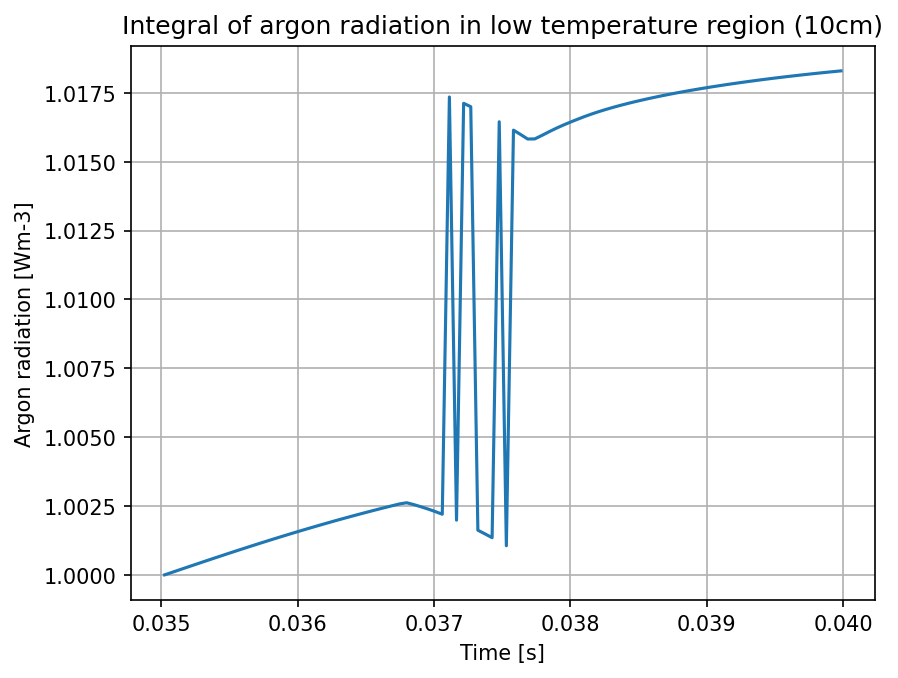

In [66]:
ds_spike = ds.sel(pos = slice(77.50, 77.60), t = slice(0.035, 0.04))
ds_sum = ds_spike.sum("pos")


fig, ax = plt.subplots(dpi = 150)
# ax2 = ax.twinx()

# ds_sum["ddt(Pe)"].plot(ax = ax2, label = "Total", lw = 3, c = "k", alpha = 0.3, ls = "--")

for param in ["Rar"]:
    data = ds_sum[param]
    first = data.isel(t=0)
    
    if first != 0:
        data = data/first
    else:
        data += 1
    
    data.plot(ax = ax, label = param)

ax.grid()
# ax.legend()
ax.set_title("Integral of argon radiation in low temperature region (10cm)")
# ax.set_yscale("symlog")

In [118]:
%matplotlib widget

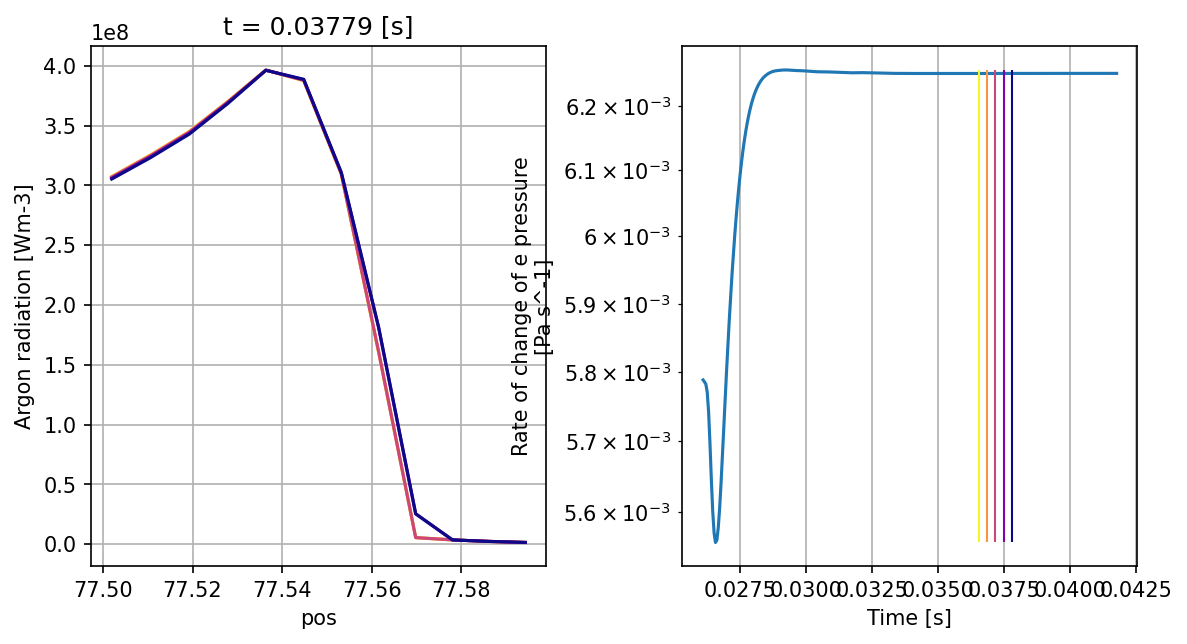

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (9, 4.5), dpi = 150)
fig.subplots_adjust(wspace = 0.3)

ds_spike = ds.sel(pos = slice(77.50, 77.60))

time_idx = np.arange(200, 230, 6)
times = ds_spike["t"].isel(t = time_idx)
colors = make_cmap("plasma", len(times))[::-1]



ax = axes[0]

for i, t in enumerate(time_idx):
    ds_spike["Rar"].isel(t=t).plot(ax = ax, c = colors[i])
# ax.set_yscale("log")
ax.grid()

ax = axes[1]

meanres = np.sqrt(np.mean(res**2, axis = 1))
meanres.plot(ax = ax)

ax.vlines(times, meanres.min(), meanres.max(), colors = colors, lw = 1)
ax.set_yscale("log")
ax.grid()

### Where is ddt(Pe) highest?

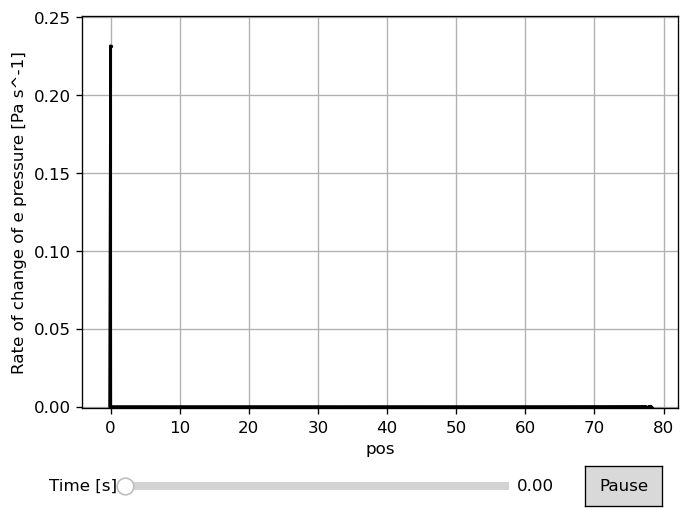

In [10]:
plt.close("all")

fig, ax = plt.subplots(dpi = 120)

res = (ds["ddt(Pe)"] * ds["dv"]) / np.sum(ds["dv"])

anim = xbout.plotting.animate.animate_line(res, ax = ax, marker = "o", c = "k", ms = 1)
ax.grid()
# res.isel(t=-1).plot(ax = ax, c = "k")

In [34]:
time_idx

array([], dtype=int32)

In [38]:
ds["t"].isel(t = time_idx).values

array([0.0365389 , 0.03914882])

In [35]:
np.arange(200, 25, 10)

array([], dtype=int32)

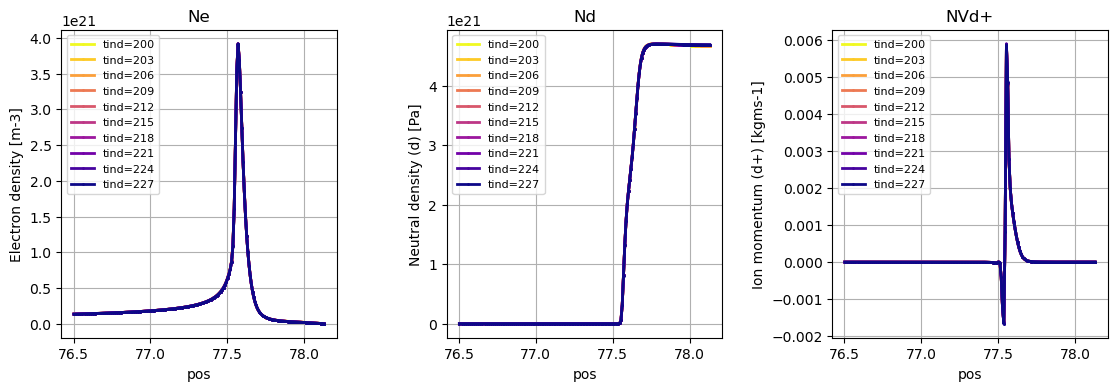

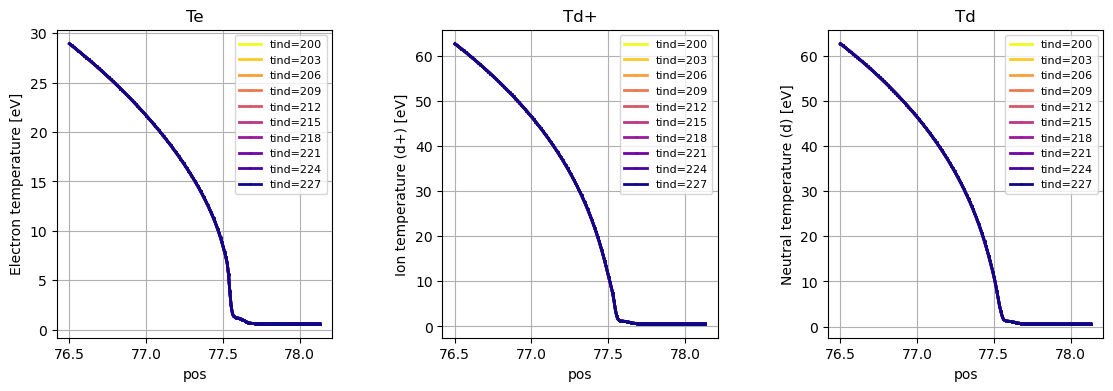

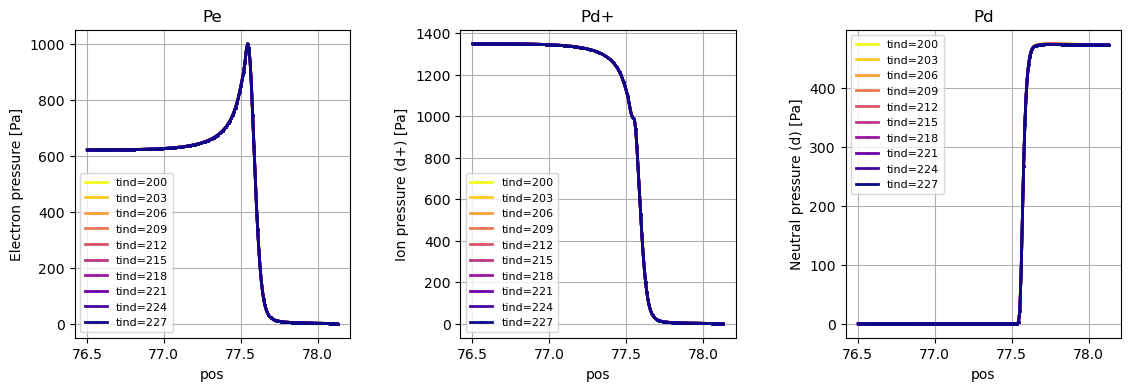

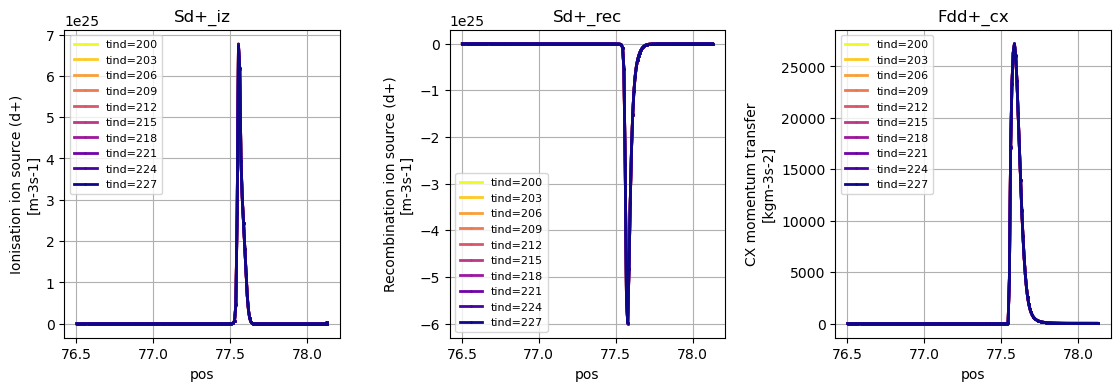

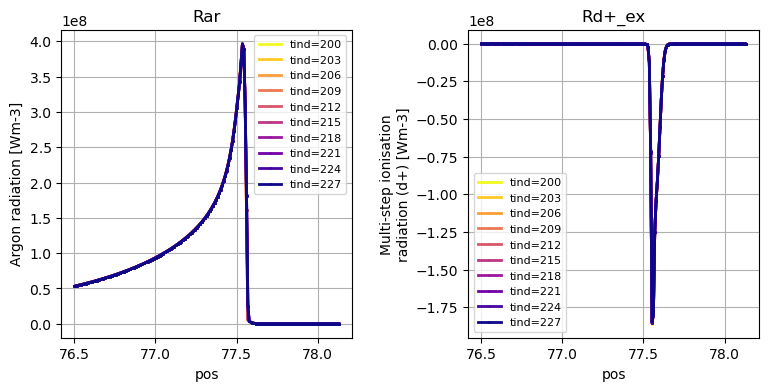

In [48]:
plt.close("all")
case = cs["mxorder1"]
ds = case.ds.isel(pos=slice(2,-1))


def plot(list_params):
    fig, axes = plt.subplots(1, len(list_params), figsize=(len(list_params)*4.5, 4), dpi = 100)
    fig.subplots_adjust(wspace = 0.4)
    
    # times = np.arange(-30,0,2)
    # times = [-6, -5, -4, -3, -2, -1]
    # times = [-15, -12, -10, -8, -6]
    # times = [-1]
    times = np.arange(200, 230, 3)
    # times = np.linspace(5, len(ds.coords["t"])-1, 10, dtype=int)
    # alphas = np.linspace(0.1,0.8, len(times))
    alphas = [1] * len(times)
    colors = make_cmap("plasma", len(times))[::-1]
    for j, param in enumerate(list_params):
        for i, tind in enumerate(times):
            data = ds[param].isel(t=tind)
            data = data.sel(pos=slice(76.5,None))
            data.plot(ax = axes[j], x = "pos", marker = "o", label = f"tind={tind}", color = colors[i], ms = 1, lw = 2, alpha = alphas[i])
            
        axes[j].grid()
        axes[j].set_title(param)
        axes[j].legend(fontsize=8)
        # axes[j].set_yscale("symlog")
        
# plot(["Rar", "Sd+_iz", "Ne", "Td+"])
plot(["Ne", "Nd", "NVd+"])
# plot(["NVd+", "NVd"])
# plot(["NVd+", ])
plot(["Te", "Td+", "Td"])
plot(["Pe", "Pd+", "Pd"])
plot(["Sd+_iz", "Sd+_rec", "Fdd+_cx"])
plot(["Rar", "Rd+_ex"])